In [1]:
import numpy as np
import scipy.linalg as la
from scipy.special import expit
from matplotlib import pyplot as plt
%matplotlib inline

from Logistic_funcs import grad_lb, grad2_lb, negloglike

# Exercise 3

##Line Search

### Problem A

We have, in our basic steepest descent method, $$\beta_{k+1} = \beta_k + \alpha_k \nabla l(\beta_k)$$

Thus $p_k = \nabla l(\beta_k)$ in this instance.

We use the backtracking method to ensure the curvature condition, thus finding the maximum alpha that satisfies the sufficient decrease condition.
This prevents us from choosing an alpha that is "too small" and must necessarily satisfy the condition without ensuring the progress we want in our algorithm.



### Problem B

In [2]:
def linesearch(x, p, f, gradf, c=1e-6, iters=1000, scale=.75):
    '''
     This function uses the wolf conditions to compute the "optimal" stepsize for 
     the next step in a descent method.

     Inputs:
     x: A P vector. The current guess vector for the optimizer of the algorithm
     p: A P vector. The descent direction.
     f: A function that takes in x as its only non-keyword argument. 
     gradf: A function that takes in x as its only non-keyword argument. This computes
         the gradient of f at x.
     upper: A float at which the maximum alpha starts
     c: A float between 0 and 1, this constant value is used in the sufficient decrease
         condition
     iters: the number of points to try between 0 and 1 for alpha (the stepsize)
     frac: A float between 0 and 1, determines the percentage by which we decrease alpha
         for each step
     
     Returns:
     suff: A boolean parameter that indicates whether the sufficiency condition was
         satisfied
     a: The desired stepsize
    '''
    # Compute the possible stepsizes to calculate
    suff = False # Boolean to determine whether the stepsize was sufficient
    fx = f(x)
    gfp = gradf(x).dot(p)
    a = 1.
    for i in np.arange(iters):
        fxap = f(x + a * p)
        if fxap <= fx + c * a * gfp:
            suff = True
            return suff, a
        else:
            a *= scale
    print "Failed to converge"
    return suff, a

In [3]:
def gradient_descent(X, y, beta, m, stepsize=1e-4, tol=1e-10, iters=1000, print_total=False):
    '''
    This function performs a simple gradient descent method to find the beta
    that minimizes the negative log likelihood function.
    
    Inputs:
    X: an m by n array of features
    y: an m vector of successes
    beta: an initial guess for the minimizer (for which we are solving)
    m: an m vector of the number of trials
    stepsize: a float, optional to specify the size of each gradient step
    tol: a float, optional to specify the error size used to indicate convergence
    iters; an integer, optional to specify the max number of iterations for the
         algorithm
         
    Returns:
    beta0: the minimizer of the negative log-likelihood
    betas: a list of the new beta for each time step
    ll: a list of the log likelihoods for each time step
    '''
    beta0 = beta
    betas = [] # Stores the new value of beta at each step
    ll = [] # Stores the new negative log likelihood at each step
    for i in np.arange(iters):
        betas.append(beta0)
        llb0 = negloglike(X, y, beta0, m)
        ll.append(llb0)
        beta1 = beta0 - stepsize * grad_lb(X, y, beta0, m)
        llb1 = negloglike(X,y,beta1, m)
        
        if np.abs(llb1 - llb0) > tol:
            beta0 = beta1            
        else:
            if print_total:
                print i, "iterations" # Print the number of iterations.
            return beta1, betas, ll 
    return beta0, betas, ll

In [28]:
def lsgd(X, y, beta, m, tol=1e-5, iters=1000, cval=.5, scaleval=.75, print_total=False):
    '''
    This function performs a line search gradient descent method to find the beta
    that minimizes the negative log likelihood function.
    
    Inputs:
    X: an m by n array of features
    y: an m vector of successes
    beta: an initial guess for the minimizer (for which we are solving)
    m: an m vector of the number of trials
    tol: a float, optional to specify the error size used to indicate convergence
    iters; an integer, optional to specify the max number of iterations for the
         algorithm
    cval: A float, option to specify the constant value used to determine stepsize
        in linesearch
    print_total: A boolean to determine whether the number of iterations it takes 
        to converge should be printed or not.
         
    Returns:
    beta0: the minimizer of the negative log-likelihood
    betas: a list of the new beta for each time step
    ll: a list of the log likelihoods for each time step
    '''
    def f(b):
        # Formats the function to be compatible with line search
        return negloglike(X, y, b, m)
    
    def gradf(b):
        # Formats the gradient of the function to be compatible with line search
        return grad_lb(X, y, b, m)
    
    beta0 = beta
    betas = [] # Stores the new value of beta at each step
    ll = [] # Stores the new negative log likelihood at each step
    step = []
    for i in np.arange(iters):
        betas.append(beta0)
        llb0 = negloglike(X, y, beta0, m)
        ll.append(llb0)
        
        p = -grad_lb(X, y, beta0, m) # The descent direction
        suff, stepsize = linesearch(beta0, p, f, gradf, c=cval, scale=scaleval)
        step.append(stepsize)
        if not suff:
            print "Stepsize insufficient"
            return "NOPE"
        
        beta1 = beta0 + stepsize * p
        llb1 = negloglike(X,y,beta1, m)
        
        #if np.abs(beta1 - beta0).sum() > tol:
        if np.abs(llb1 - llb0) > tol:
            beta0 = beta1            
        else:
            if print_total:
                print i, "iterations" # Print the number of iterations.
            return beta1, betas, ll, step
    return beta0, betas, ll, step

In [47]:
# Generate some random data with a form similar to the data given
m = 500
n = 11
# Make sure that the first column of X is all ones to handle the intercept term
X = np.hstack((np.ones((m,1)),np.random.rand(m,n)))
# Set y to be a random vector of ones and zeros
y = (np.random.rand(m) > .5).astype(float)
# Let m be a vector of single trials
M = np.ones(m)

b = np.random.rand(n+1)

In [55]:
beta0, betas, ll, step = lsgd(X, y, b, M, tol=1e-10, print_total=True)
beta1, betas1, ll1 = gradient_descent(X, y, b, M, tol=1e-10, iters=50000, print_total=True)

439 iterations
22650 iterations


In [57]:
# Make sure that both algorithms are converging to the same value of beta
y1 = X.dot(beta0)
y2 = X.dot(beta1)
print la.norm(y1 - y)
print la.norm(y2 - y)
print la.norm(beta0 - beta1)

15.5236625876
15.5235155744
0.000319432091837


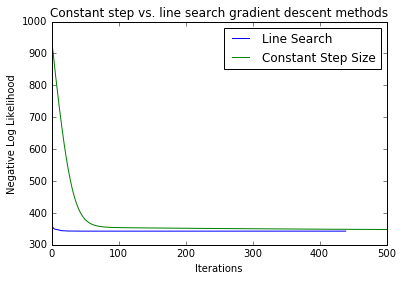

In [58]:
plt.plot(ll, label="Line Search")
plt.plot(ll1, label="Constant Step Size")
plt.xlim(0, 500)
plt.legend(loc="best")
plt.xlabel('Iterations')
plt.ylabel('Negative Log Likelihood')
plt.title('Constant step vs. line search gradient descent methods')
plt.show()

551 iterations
225 iterations
96 iterations
111 iterations
448 iterations


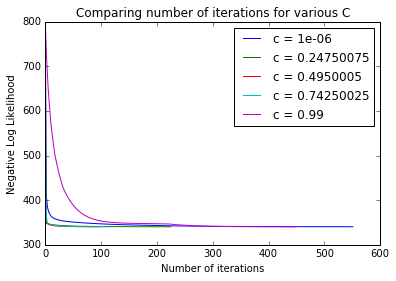

In [32]:
# Comparing convergence for various values of C
for i in np.linspace(1e-6, .99, 5):
    beta0, betas, ll, step = lsgd(X, y, b, M, tol=1e-3, cval=i, print_total=True)
    plt.plot(ll, label='c = ' + str(i))
plt.legend(loc='best')
plt.ylabel("Negative Log Likelihood")
plt.xlabel("Number of iterations")
plt.title("Comparing number of iterations for various C")
plt.show()

217 iterations
123 iterations
92 iterations
103 iterations
123 iterations


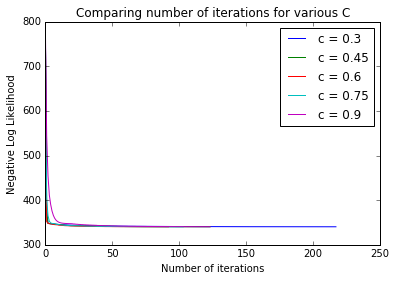

In [33]:
# Narrowing our convergence for various values of C
for i in np.linspace(.3, .9, 5):
    beta0, betas, ll, step = lsgd(X, y, b, M, tol=1e-3, cval=i, print_total=True)
    plt.plot(ll, label='c = ' + str(i))
plt.legend(loc='best')
plt.ylabel("Negative Log Likelihood")
plt.xlabel("Number of iterations")
plt.title("Comparing number of iterations for various C")
plt.show()

612 iterations
227 iterations
69 iterations
30 iterations
45 iterations


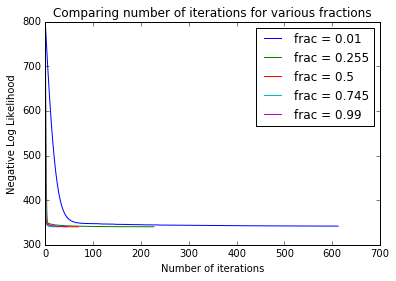

In [34]:
# Narrowing our convergence for various values of frac
for i in np.linspace(.01, .99, 5):
    beta0, betas, ll, step = lsgd(X, y, b, M, tol=1e-3, scaleval=i, cval=.5, print_total=True)
    plt.plot(ll, label='frac = ' + str(i))
plt.legend(loc='best')
plt.ylabel("Negative Log Likelihood")
plt.xlabel("Number of iterations")
plt.title("Comparing number of iterations for various fractions")
plt.show()

Intuitively, it appears that the choice of fraction of alpha on which to iterate  does not effect the overall rate of convergence of the algorithm

In [35]:
%%timeit
beta0, betas, ll, step = lsgd(X, y, b, M, tol=1e-4, cval=.5, scaleval=.99, print_total=True)

46 iterations
46 iterations
46 iterations
46 iterations
1 loops, best of 3: 3.98 s per loop


In [27]:
%%timeit
beta1, betas1, ll1 = gradient_descent(X, y, b, M, tol=1e-4, iters=10000)

1 loops, best of 3: 1.13 s per loop


## Quasi Newton

###Problem A

### Problem B